In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 1 default, 0 interactive, 1 GC (on 4 virtual cores)
Environment:
  JULIA_PYTHONCALL_EXE = @PyCall


In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/Repos/article-expmde`


In [3]:
using LinearAlgebra
using MatrixDepot
using DelimitedFiles
using ProgressMeter

include("expm_pade1313.jl")
include("expm_de.jl")

[ Info: verify download of index files...
[ Info: reading database
[ Info: adding metadata...
[ Info: adding svd data...
[ Info: writing database
[ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index


expm_de (generic function with 2 methods)

In [4]:
mdinfo()

### Currently loaded Matrices

| builtin(#)  |             |              |             |               |
|:----------- |:----------- |:------------ |:----------- |:------------- |
| 1 baart     | 13 fiedler  | 25 invhilb   | 37 parter   | 49 shaw       |
| 2 binomial  | 14 forsythe | 26 invol     | 38 pascal   | 50 smallworld |
| 3 blur      | 15 foxgood  | 27 kahan     | 39 pei      | 51 spikes     |
| 4 cauchy    | 16 frank    | 28 kms       | 40 phillips | 52 toeplitz   |
| 5 chebspec  | 17 gilbert  | 29 lehmer    | 41 poisson  | 53 tridiag    |
| 6 chow      | 18 golub    | 30 lotkin    | 42 prolate  | 54 triw       |
| 7 circul    | 19 gravity  | 31 magic     | 43 randcorr | 55 ursell     |
| 8 clement   | 20 grcar    | 32 minij     | 44 rando    | 56 vand       |
| 9 companion | 21 hadamard | 33 moler     | 45 randsvd  | 57 wathen     |
| 10 deriv2   | 22 hankel   | 34 neumann   | 46 rohess   | 58 wilkinson  |
| 11 dingdong | 23 heat     | 35 oscillate | 47 rosser   | 59 wing       |
| 12 erdrey   | 24 hilb     | 36 parallax  | 48 sampling |               |

| user(#) |
|:------- |

| Groups  |       |       |         |        |         |           |     |     |     |     |     |
|:------- |:----- |:----- |:------- |:------ |:------- |:--------- |:--- |:--- |:--- |:--- |:--- |
| all     | local | eigen | illcond | posdef | regprob | symmetric |     |     |     |     |     |
| builtin | user  | graph | inverse | random | sparse  |           |     |     |     |     |     |

| Suite Sparse | of   |
|:------------ |:---- |
| 0            | 2904 |

| MatrixMarket | of  |
|:------------ |:--- |
| 0            | 498 |


In [5]:
mkpath("fig")
mkpath("matrix/test5")
matnames = []
for matname in mdlist(:builtin)
    try
        A = matrixdepot(matname, 10) |> Matrix
        m, n = size(A)
        @assert m == n "m != n. m = $(m) and n = $(n)."
        @assert n == 10 "n != 10. n = $(n)."
        λ = eigvals(A)
        λ_right = λ[λ |> real |> argmax]

        Ã = A - λ_right*I*(1 + 0im)
        Ã_big = big.(Ã)
        F̃_big = expm_pade1313(Ã_big)
        F̃ = ComplexF64.(F̃_big)
        writedlm("matrix/test5/$(matname)_A.txt", Ã)
        writedlm("matrix/test5/$(matname)_Ref.txt", F̃)
        push!(matnames, matname)
    catch e
        println(matname)
        println(e)
        println()
    end
end

blur
AssertionError("n != 10. n = 100.")

hadamard
ArgumentError("n must be positive integer and a power of 2.")

neumann
AssertionError("n != 10. n = 100.")

parallax
AssertionError("m != n. m = 26 and n = 10.")

phillips
ErrorException("The dimension of the matrix must be a multiple of 4.")

poisson
AssertionError("n != 10. n = 100.")

rosser
ArgumentError("n must be positive integer and a power of 2.")

wathen
AssertionError("n != 10. n = 341.")



In [6]:
print(matnames)

Any["baart", "binomial", "cauchy", "chebspec", "chow", "circul", "clement", "companion", "deriv2", "dingdong", "erdrey", "fiedler", "forsythe", "foxgood", "frank", "gilbert", "golub", "gravity", "grcar", "hankel", "heat", "hilb", "invhilb", "invol", "kahan", "kms", "lehmer", "lotkin", "magic", "minij", "moler", "oscillate", "parter", "pascal", "pei", "prolate", "randcorr", "rando", "randsvd", "rohess", "sampling", "shaw", "smallworld", "spikes", "toeplitz", "tridiag", "triw", "ursell", "vand", "wilkinson", "wing"]

In [7]:
println("The number of test matrices: $(length(matnames))")

The number of test matrices: 51


In [8]:
struct Result
    matname::String
    ss::Float64
    de_ϵ08::Float64
    de_ϵ16::Float64
end

In [9]:
results = Vector{Result}()
for matname in matnames
    A = readdlm("matrix/test5/$(matname)_A.txt", '\t', ComplexF64)
    F = readdlm("matrix/test5/$(matname)_Ref.txt", '\t', ComplexF64)
    X_ss = exp(A)
    X_de_ϵ08 = expm_de(A, ϵ=1e-8).X
    X_de_ϵ16 = expm_de(A, ϵ=1e-16).X

    result = Result(
        matname,
        opnorm(F - X_ss),
        opnorm(F - X_de_ϵ08),
        opnorm(F - X_de_ϵ16),
    )
    push!(results, result)
end

In [10]:
println(results)

Result[Result("baart", 1.8458258622418101e-16, 6.557161539335715e-13, 1.0911191630967794e-15), Result("binomial", 4.0431062444575534e-14, 2.2112013401100801e-13, 8.67101557945572e-15), Result("cauchy", 6.358184931080135e-16, 6.556232508629473e-13, 1.1163496847257694e-15), Result("chebspec", 2.8871739523775124e-9, 15.54029414102297, 16.45054555372352), Result("chow", 2.019212306824227e-15, 6.560427487122559e-14, 2.966074945964343e-15), Result("circul", 2.6585192479416707e-12, 3.301929566989645e-12, 2.6456545326711336e-12), Result("clement", 1.470792680328177e-9, 1.471273096269423e-9, 1.4707910608399248e-9), Result("companion", 4.888815121172405e-16, 6.551848531519877e-13, 1.9781286358668863e-15), Result("deriv2", 1.0204507067528942e-15, 6.565966757592914e-13, 1.2216045377967276e-15), Result("dingdong", 4.977054514555378e-15, 6.558016831541685e-13, 1.3360080309431962e-15), Result("erdrey", 2.888652845656729e-15, 6.555786611463106e-13, 1.2847628688898797e-15), Result("fiedler", 5.83751441

In [11]:
results = Result[Result("baart", 1.8458258622418101e-16, 6.557161539335715e-13, 1.0911191630967794e-15), Result("binomial", 4.0431062444575534e-14, 2.2112013401100801e-13, 8.67101557945572e-15), Result("cauchy", 6.358184931080135e-16, 6.556232508629473e-13, 1.1163496847257694e-15), Result("chebspec", 2.8871739523775124e-9, 15.54029414102297, 16.45054555372352), Result("chow", 2.019212306824227e-15, 6.560427487122559e-14, 2.966074945964343e-15), Result("circul", 2.6585192479416707e-12, 3.301929566989645e-12, 2.6456545326711336e-12), Result("clement", 1.470792680328177e-9, 1.471273096269423e-9, 1.4707910608399248e-9), Result("companion", 4.888815121172405e-16, 6.551848531519877e-13, 1.9781286358668863e-15), Result("deriv2", 1.0204507067528942e-15, 6.565966757592914e-13, 1.2216045377967276e-15), Result("dingdong", 4.977054514555378e-15, 6.558016831541685e-13, 1.3360080309431962e-15), Result("erdrey", 1.7748676502576154e-15, 6.557557729426738e-13, 1.1354222209890417e-15), Result("fiedler", 5.83751441072048e-15, 6.552446898410119e-13, 1.453957924368259e-15), Result("forsythe", 4.380743162514642e-16, 1.962570633872545e-14, 1.3748535030367745e-15), Result("foxgood", 1.4233196194946833e-14, 6.560386219513532e-13, 1.1401733940911927e-15), Result("frank", 1.1085500686410049e-15, 2.129645301850832e-13, 2.1502440776500067e-15), Result("gilbert", 9.700984879473309e-15, 6.558452690388672e-13, 1.1324720851485008e-15), Result("golub", 3.440488881337977e-14, 8.508903983085689e-13, 1.4626297194434366e-14), Result("gravity", 9.179811494545604e-16, 6.556080674215236e-13, 1.069281849941818e-15), Result("grcar", 7.269696714609283e-16, 4.061180849979325e-9, 4.849865278548923e-15), Result("hankel", 2.847203848089879e-12, 3.495964452163443e-12, 2.839626474425427e-12), Result("heat", 3.906011233622921e-17, 2.1351770388064544e-13, 1.9108171286943396e-15), Result("hilb", 3.997289967975085e-15, 6.5570015343121e-13, 1.1568472857688047e-15), Result("invhilb", 660.9751126639906, 660.9708365397527, 660.970836539752), Result("invol", 64667.945031939635, 11.139192304713438, 11.137369553906998), Result("kahan", 2.002202115336924e-16, 6.564046482412518e-13, 1.801491011942923e-15), Result("kms", 1.1653908215091393e-15, 6.55692201528653e-13, 1.1691902055048514e-15), Result("lehmer", 2.026917174499548e-15, 6.559610894828955e-13, 1.1797441170656232e-15), Result("lotkin", 3.4791820699007387e-16, 6.556761123488575e-13, 1.4167352950288848e-15), Result("magic", 8.728160694270507e-11, 8.792689215663676e-11, 8.727053524340873e-11), Result("minij", 9.955606042080313e-15, 6.542000672484459e-13, 2.2220890062883976e-15), Result("moler", 5.296540966830783e-13, 1.1646079320694351e-12, 5.083393017148365e-13), Result("oscillate", 2.30565442984546e-16, 6.5616351941431e-13, 1.5782845379483969e-15), Result("parter", 7.154139766742577e-16, 3.1959588116788917e-12, 1.7826804470070384e-15), Result("pascal", 9.539913064215859e-9, 9.507612728823256e-9, 9.506101851972486e-9), Result("pei", 1.0799757879653771e-9, 1.0806296857346453e-9, 1.0799731706145995e-9), Result("prolate", 1.4971524445052484e-13, 7.786559023719369e-13, 1.2223497056779113e-13), Result("randcorr", 1.1458746635052237e-15, 6.558866675675226e-13, 1.6382661449943508e-15), Result("rando", 6.275597629924105e-16, 6.560318659690672e-13, 1.177690227661848e-15), Result("randsvd", 2.4802015215414845e-16, 6.559437767631274e-13, 1.9056392628934634e-15), Result("rohess", 2.1093835234706054e-16, 6.564761131235673e-13, 1.5147654282855688e-15), Result("sampling", 1.4138832705424822e-10, 1.1673260412476539e-8, 3.069967625889396e-8), Result("shaw", 5.910588114755413e-15, 6.558334318318413e-13, 1.3079420135624948e-15), Result("smallworld", 2.699136844513554e-15, 6.556227056966731e-13, 1.2782284999083002e-15), Result("spikes", 2.482667520949172e-16, 6.559319681479719e-13, 1.6754581477057465e-15), Result("toeplitz", 1.1361866229583281e-14, 6.59991310465435e-13, 3.668508112476508e-15), Result("tridiag", 9.544544029506801e-16, 6.560263793456209e-13, 1.3387482452428804e-15), Result("triw", 6.870248438488053e-16, 6.413239368982183e-14, 2.5844596577890144e-15), Result("ursell", 1.602949294400319e-14, 6.564762382620413e-13, 1.679248544026336e-15), Result("vand", 3.797299815925875e-8, 4.158352471383621e-9, 4.158604980727409e-9), Result("wilkinson", 1.4300457187883884e-15, 6.555747026502924e-13, 1.4900045300202218e-15), Result("wing", 2.312107055730875e-16, 6.565876369038604e-13, 1.7807327417474554e-15)];

In [12]:
using PyPlot

In [13]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 8
rcParams["axes.titlesize"] = 8

8

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


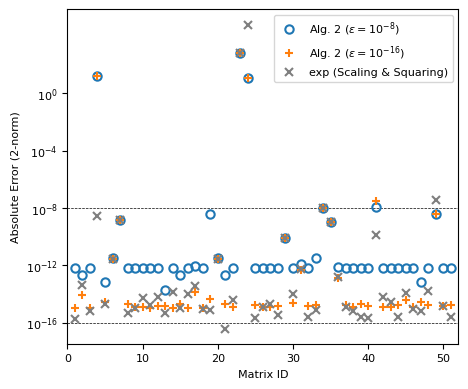

In [16]:
fig, ax = subplots(1, 1, figsize=[12, 10]/2.54)

x = 1:length(results)
err_ss = [r.ss for r in results]
err_de_08 = [r.de_ϵ08 for r in results]
err_de_16 = [r.de_ϵ16 for r in results]

ax.plot([0, 52], [1e-8, 1e-8], c="k", lw="0.5", ls="--")
ax.plot([0, 52], [1e-16, 1e-16], c="k", lw="0.5", ls="--")
ax.plot(x, err_de_08, label="Alg. 2 (\$\\epsilon=10^{-8}\$)", lw=0,
    c="tab:blue", marker="o", markerfacecolor="None",
    markeredgewidth=1.5,
)
ax.plot(x, err_de_16, label="Alg. 2 (\$\\epsilon=10^{-16}\$)", lw=0,
    c="tab:orange", marker="+", markeredgewidth=1.5,
)
ax.plot(x, err_ss, label="exp (Scaling & Squaring)", lw=0,
    c="tab:gray", marker="x", markeredgewidth=1.5,
)

ax.set_xlim(0, 52)
ax.set_xlabel("Matrix ID")
ax.set_ylabel("Absolute Error (2-norm)")
# ax.set_ylim(1e-16, 1e3)
ax.set_yscale("log")
ax.set_yticks([1e-16, 1e-12, 1e-8, 1e-4, 1e-0])
ax.legend()
fig.tight_layout()
fig.savefig("fig/test5.pdf")
show()